**Project Title: "Thyroid Cancer Recurrence Detection using classification**

**Submitted by:**  Jefferson C. Polano 

**CYS:** CPE32

**Student Number:** 202130014


In [ ]:
# Ito yung ginagamit ko na code sa excel para magkaroon ng missing value para mahirapan ang model to predict 
##Sub RandomlyClearCells()
##    Dim rng As Range
##    Dim cell As Range
##    Dim totalCells As Integer
##    Dim deleteCount As Integer
##    Dim i As Integer

##    Set rng = Range("A2:H768")
##    totalCells = rng.Count
##    deleteCount = Int(totalCells * 0.3)

##    Application.ScreenUpdating = False
##    For i = 1 To deleteCount
##        Set cell = rng.Cells(Int((totalCells) * Rnd + 1))
##        cell.ClearContents
##    Next i
##    Application.ScreenUpdating = True
##    MsgBox deleteCount & " cells cleared."
##End Sub


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import time


In [53]:
# Niload ko yung dataset
# Ang original dataset ay wala talagang missing values pero ang ginawa ko para magawa ng mas maayos ang pre processing techniques inedit ko siya sa excel to miss values. 
# Kaya dito makikita natin maraming mga missing. 
df = pd.read_csv('thyroid_data.csv')
print(df)
print(df.shape)

      Age Gender Hx Radiothreapy Adenopathy       Pathology     Focality  \
0    27.0      F             NaN        NaN  Micropapillary          NaN   
1    34.0      F              No        NaN  Micropapillary          NaN   
2    30.0      F              No        NaN  Micropapillary          NaN   
3     NaN      F             NaN         No  Micropapillary          NaN   
4    62.0      F              No         No             NaN  Multi-Focal   
..    ...    ...             ...        ...             ...          ...   
378   NaN      M             Yes      Right       Papillary          NaN   
379   NaN      M             NaN  Extensive       Papillary          NaN   
380  72.0    NaN              No  Bilateral             NaN  Multi-Focal   
381  61.0      M             Yes  Extensive    Hurthel cell  Multi-Focal   
382  67.0      M              No  Bilateral       Papillary          NaN   

     Risk    T    N    M Stage               Response Recurred  
0     Low  T1a   N0   

In [54]:
# Dito makikita natin ang daming null values kaya bago natin gawin ang pagtrain sa model na gagawin I need to clean the data first. 
df.isna().sum()

Age                111
Gender             113
Hx Radiothreapy    128
Adenopathy         113
Pathology          111
Focality           114
Risk               118
T                  120
N                  118
M                  107
Stage              103
Response           115
Recurred           123
dtype: int64

In [55]:
# Dito nilinis muna yung laman para maging yes o no lang sa recurred at cinonvert siya into numeric. 
# Based sa tinuro dito sa paggawa ng model ay lahat ng mga categorical kailangan into numerical kasi nababasa ng maayos yung code kapag hindi siya puro numbers. 
df['Recurred'] = df['Recurred'].astype(str).str.strip().str.lower()
df = df[df['Recurred'].isin(['yes', 'no'])]
df['Recurred'] = df['Recurred'].map({'no': 0, 'yes': 1})



In [56]:
#Dito pinagpatuloy lang yung pagpapalit ng mga value from category into numeric.
# Kapag may nawawalang value sa column pinapalit ito ng madalas meron sa column na iyon gamit ang fillna(mode()) .  
# Gamit ang gpt nagpatulong ako sa pagconvert ng maayos. 
ordinal_cols = ['Risk', 'T', 'N', 'M', 'Stage']
ordinal_mappings = {
    'Risk': {'Low': 0, 'Intermediate': 1, 'High': 2},
    'T': {'T1a': 0, 'T1b': 1, 'T2': 2, 'T3a': 3, 'T3b': 4, 'T4a': 5, 'T4b': 6},
    'N': {'N0': 0, 'N1a': 1, 'N1b': 2},
    'M': {'M0': 0, 'M1': 1},
    'Stage': {'I': 1, 'II': 2, 'III': 3, 'IVA': 4, 'IVB': 5}
}
for col in ordinal_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = df[col].map(ordinal_mappings[col])


In [57]:
# Dito naman kapag may kulang katulad ng edad, pinapalitan agad ito based sa average age ng buong dataset. 
# Dito naman kapag categorical column naman, ang madalas na gamitin ay ang mode kasi madali ipredict ang value kapag ito ginamit. 
# Para mabilis imaintain ang mga nawawalang values mas maigi na gamitin ang for loop. 
df['Age'] = df['Age'].fillna(df['Age'].mean())
nominal_cols = ['Gender', 'Hx Radiothreapy', 'Adenopathy', 'Pathology', 'Focality', 'Response']
for col in nominal_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [58]:
# Dito makikita natin na all clean na ang data, ang susunod na gawin is itrain na natin yung mga gusto nating model gamit parin ang preprocessing techniques at mga ibang tinuro sa classification machine learning. 
df.isna().sum()

Age                0
Gender             0
Hx Radiothreapy    0
Adenopathy         0
Pathology          0
Focality           0
Risk               0
T                  0
N                  0
M                  0
Stage              0
Response           0
Recurred           0
dtype: int64

In [59]:
# Dito hiniwalay na yung features at target variable. 
# Gamit ang train_test_split makikita natin ang percentage na gagamitin sa training set ay 80% at sa test set naman ay 20%
# Nag split ako kaagad dahil para sa iwas data leakage na. 

#5. Split data
X = df.drop(columns='Recurred')
y = df['Recurred']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)




In [60]:
# 6. Split feature types
# Gagamitin ang mga ito para madaling icode sa transformer or pipeline. 
numerical_cols = ['Age']
categorical_cols = nominal_cols
encoded_ordinal_cols = ordinal_cols


In [61]:
#Dito pinapalitan ang mga nawawalang blankong Age sa training set gamit ang average nito, saka ginagamit ang parehong average para punan ang test set; pagkatapos, isini-standardize (zero mean, unit variance) ang parehong train at test values gamit ang mean at std na kinuha mula lang sa training data. 
# 7. Impute & scale numerical
num_imputer = SimpleImputer(strategy='mean')
X_train_num = num_imputer.fit_transform(X_train[numerical_cols])
X_test_num = num_imputer.transform(X_test[numerical_cols])

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)


In [62]:
# Dito sa pagimpute, makikita natin ang pagfit sa train at transform sa test. 
# Ang natutunan ko na ang role ng imputer dito ay pinapalitan ang nawawalang value gamit ang pinaka madalas na lumabas sa column 
# 8. Impute + encode nominal
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_cols]), columns=categorical_cols)
X_test_cat = pd.DataFrame(cat_imputer.transform(X_test[categorical_cols]), columns=categorical_cols)


In [63]:
# Dito nag one hot encode ako sa lahat ng categorical columns para iwas multicollinearity sa pamamagitan ng drop='first', at ini-ignore ang anumang bagong value na maaaring lumitaw sa test set. Pagkatapos, ginagamit ang parehong column layout upang i-transform ang test data.
# Nag OneHotEncoder ako para makagawa din ng dummy columns

# sparse_output=False
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_train_cat_enc = pd.DataFrame(ohe.fit_transform(X_train_cat), columns=ohe.get_feature_names_out(categorical_cols))
X_test_cat_enc = pd.DataFrame(ohe.transform(X_test_cat), columns=ohe.get_feature_names_out(categorical_cols))


In [64]:
# Pinag-isa ko ang lahat ng na-pre-process na feature na-scale na Age, one-hot-encoded na categorical, at numerong ordinal—sa isang training matrix (X_train_all) at katugmang test matrix (X_test_all).
# 9. Combine all features
X_train_all = np.hstack([
    X_train_num,
    X_train_cat_enc.values,
    X_train[encoded_ordinal_cols].values
])
X_test_all = np.hstack([
    X_test_num,
    X_test_cat_enc.values,
    X_test[encoded_ordinal_cols].values
])


In [65]:
# Naglagay na ako ng mga models para alamin kung anong pinakaeffective sa pagpredict
# 10. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "MLP Neural Network": MLPClassifier(max_iter=1000, random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42)
}


In [ ]:
# Sa loop, bawat modelo ay sumasailalim sa k-fold cross-validation; kinukuwenta ang recall sa bawat fold, kinukuha ang average at standard deviation, iniipon ang mga score sa results, at ini-o-output ang “Mean Recall” at “Std” per algorithm kaya mabilis nating namamapa kung aling modelo ang pinakamataas at pinakamatatag sa pagtukoy ng mga nag-recur.
# 11. Cross-validation recall scores
print("Model Recall Scores (Cross-Validation):")
kf = KFold(n_splits=6, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_all, y_train, cv=kf, scoring='recall')
    results.append(scores)
    print("{}: Mean Recall = {:.4f}, Std = {:.4f}".format(name, scores.mean(), scores.std()))


Model Recall Scores (Cross-Validation):
Logistic Regression: Mean Recall = 0.8476, Std = 0.0896
KNN: Mean Recall = 0.7462, Std = 0.1522
Decision Tree: Mean Recall = 0.8202, Std = 0.1385
Random Forest: Mean Recall = 0.8202, Std = 0.1527
Gradient Boosting: Mean Recall = 0.8273, Std = 0.1273
SVM: Mean Recall = 0.8515, Std = 0.1201
Naive Bayes: Mean Recall = 0.8387, Std = 0.1390
AdaBoost: Mean Recall = 0.8330, Std = 0.1374
MLP Neural Network: Mean Recall = 0.8515, Std = 0.1201
Extra Trees: Mean Recall = 0.8330, Std = 0.1374


In [68]:
# 12. Hyperparameter tuning
param_grids = {
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs'], 'max_iter': [1000]},
    "KNN": {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
    "Decision Tree": {'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']},
    "Naive Bayes": {},
    "AdaBoost": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    "MLP Neural Network": {'hidden_layer_sizes': [(50,), (100,), (100, 50)], 'activation': ['relu', 'tanh'], 'solver': ['adam'], 'alpha': [0.0001, 0.001], 'learning_rate': ['constant', 'adaptive']},
    "Extra Trees": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
}

print("\nStarting Hyperparameter Tuning...")
best_params_dict = {}

for name, model in models.items():
    if not param_grids[name]:
        print(f"Skipping tuning for {name} (no hyperparameters).")
        continue

    print(f"\nTuning {name}...")
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[name],
        n_iter=10,
        scoring='recall',
        cv=kf,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    start = time.time()
    random_search.fit(X_train_all, y_train)
    elapsed = time.time() - start

    best_params_dict[name] = random_search.best_params_
    print(f"Best params: {random_search.best_params_}")
    print(f"Recall Score: {random_search.best_score_:.4f} | Time: {elapsed:.2f}s")

# Update models
for name in best_params_dict:
    models[name] = models[name].set_params(**best_params_dict[name])

    #Gumamit ako hyperparameter grid para sa bawat algorithm at in-apply ang RandomizedSearchCV (10 random combinations, k-fold CV, recall metric) upang hanapin ang pinakamabisang set-up. Sa loob ng loop, nilalaktawan ang Naive Bayes sapagkat wala itong mahahalagang hyperparameter, habang ang ibang modelo ay isinasailalim sa random search; matapos i-fit, iniimbak sa best_params_dict ang pinakamahusay na kumbinasyon at iniuulat ang mean recall at tumagal na oras. 
    # Sa loop, bawat modelo ay sinusuri kung may hyperparameter grid. Kapag meron, pupunta ito sa RandomizedSearchCV (10 random combos, k-fold CV, recall metric) na tumatakbo nang parallel at may fixed seed para maulit. Pagkatapos ng paghahanap, kinukuha ang best recall at ang kaukulang hyperparameters, iniimbak sa best_params_dict, at ini-o-output kasama ang oras na ginugol. Kung walang grid, gaya ng Naive Bayes, nilalaktawan lang ito.



Starting Hyperparameter Tuning...

Tuning Logistic Regression...
Fitting 6 folds for each of 8 candidates, totalling 48 fits


C:\Users\Jefferson Polano\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'solver': 'liblinear', 'max_iter': 1000, 'C': 1}
Recall Score: 0.8533 | Time: 4.81s

Tuning KNN...
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best params: {'weights': 'uniform', 'p': 1, 'n_neighbors': 3}
Recall Score: 0.7667 | Time: 0.36s

Tuning Decision Tree...
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20}
Recall Score: 0.8487 | Time: 0.19s

Tuning Random Forest...
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Recall Score: 0.8376 | Time: 1.54s

Tuning Gradient Boosting...
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
Recall Score: 0.8273 | Time: 1.19s

Tuning SVM...
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best params: {'kernel': 'rbf', 'gam

C:\Users\Jefferson Polano\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'n_estimators': 100, 'learning_rate': 1}
Recall Score: 0.8828 | Time: 1.19s

Tuning MLP Neural Network...
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best params: {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh'}
Recall Score: 0.8828 | Time: 2.20s

Tuning Extra Trees...
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Recall Score: 0.8515 | Time: 0.97s


C:\Users\Jefferson Polano\AppData\Local\Temp\ipykernel_31384\3025581667.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=models.keys(), vert=False)


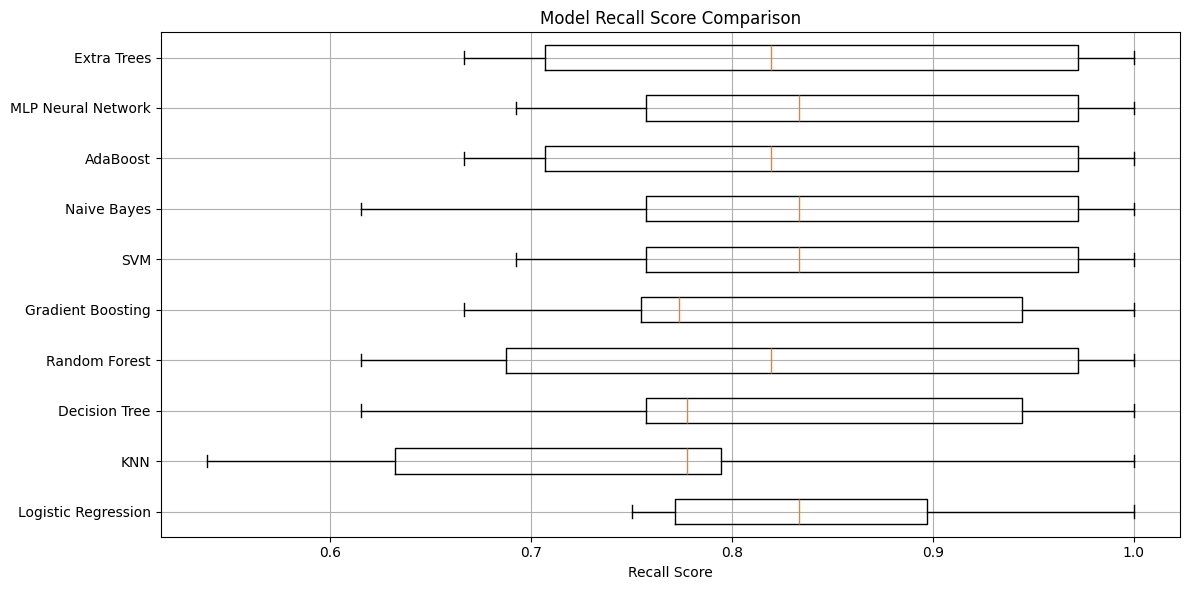


Logistic Regression Train Accuracy: 95.67%
Logistic Regression Test Accuracy: 94.23%
Confusion Matrix:
[[37  1]
 [ 2 12]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9487    0.9737    0.9610        38
           1     0.9231    0.8571    0.8889        14

    accuracy                         0.9423        52
   macro avg     0.9359    0.9154    0.9250        52
weighted avg     0.9418    0.9423    0.9416        52


KNN Train Accuracy: 95.19%
KNN Test Accuracy: 86.54%
Confusion Matrix:
[[37  1]
 [ 6  8]]
Classification Report:
              precision    recall  f1-score   support

           0     0.8605    0.9737    0.9136        38
           1     0.8889    0.5714    0.6957        14

    accuracy                         0.8654        52
   macro avg     0.8747    0.7726    0.8046        52
weighted avg     0.8681    0.8654    0.8549        52


Decision Tree Train Accuracy: 94.23%
Decision Tree Test Accuracy: 88.46%
Confusion Ma

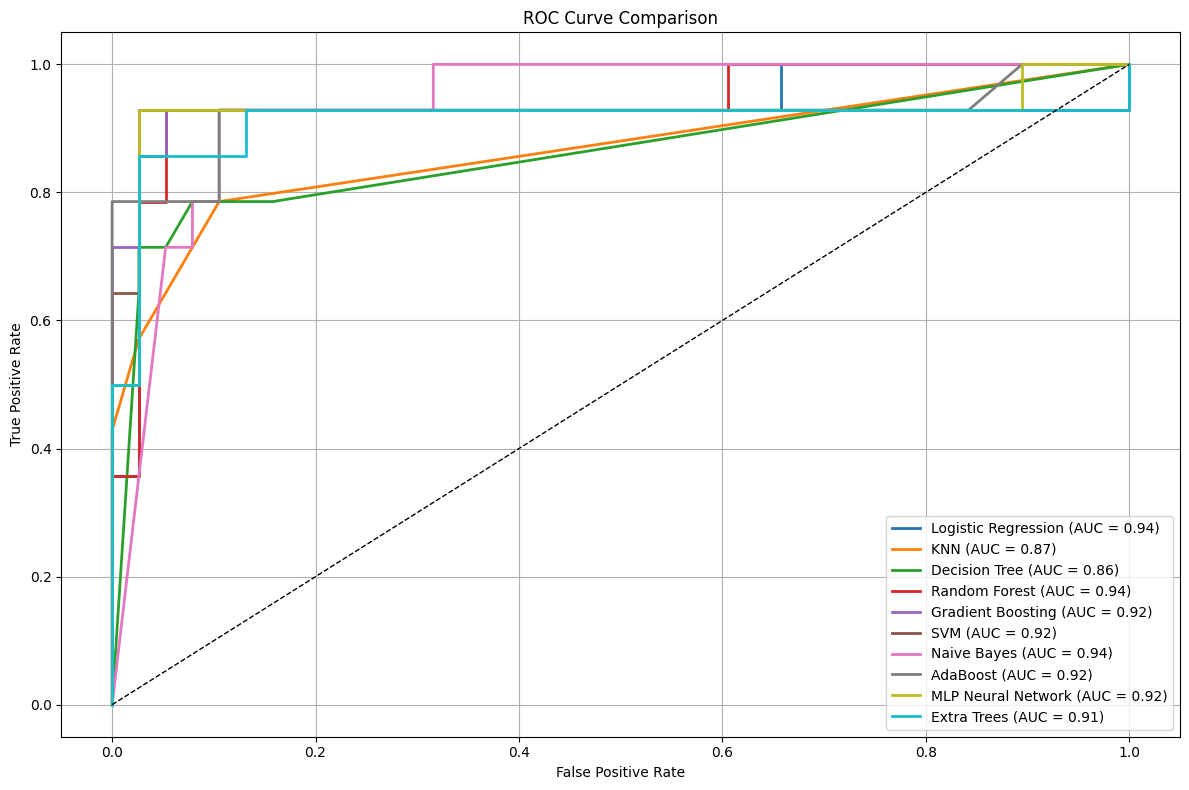

In [ ]:
# Nag-boxplot muna ako ng recall scores para makita, sa isang tingin, kung aling modelo ang pinakamatataas at pinakastable sa CV. Pagkatapos ay nire-train ko bawat modelo sa buong training set, kinuha ang train/test accuracy, confusion matrix, at classification report, at iginuhit ang kanilang ROC curves (may AUC labels) sa iisang graph—kaya klaro kung sino ang may pinakamahusay na balanse ng true- at false-positive rates. May try-except para hindi maputol kapag may modelong walang predict_proba.
# 13. Boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(results, labels=models.keys(), vert=False)
plt.title("Model Recall Score Comparison")
plt.xlabel("Recall Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# 14. Final Evaluation + ROC
plt.figure(figsize=(12, 8))

for name, model in models.items():
    try:
        model.fit(X_train_all, y_train)
        y_pred_train = model.predict(X_train_all)
        y_pred_test = model.predict(X_test_all)
        y_proba = model.predict_proba(X_test_all)[:, 1]

        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        print(f"\n{name} Train Accuracy: {train_acc:.2%}")
        print(f"{name} Test Accuracy: {test_acc:.2%}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred_test))
        print("Classification Report:")
        print(classification_report(y_test, y_pred_test, digits=4))
    except Exception as e:
        print(f"⚠️ Error in {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


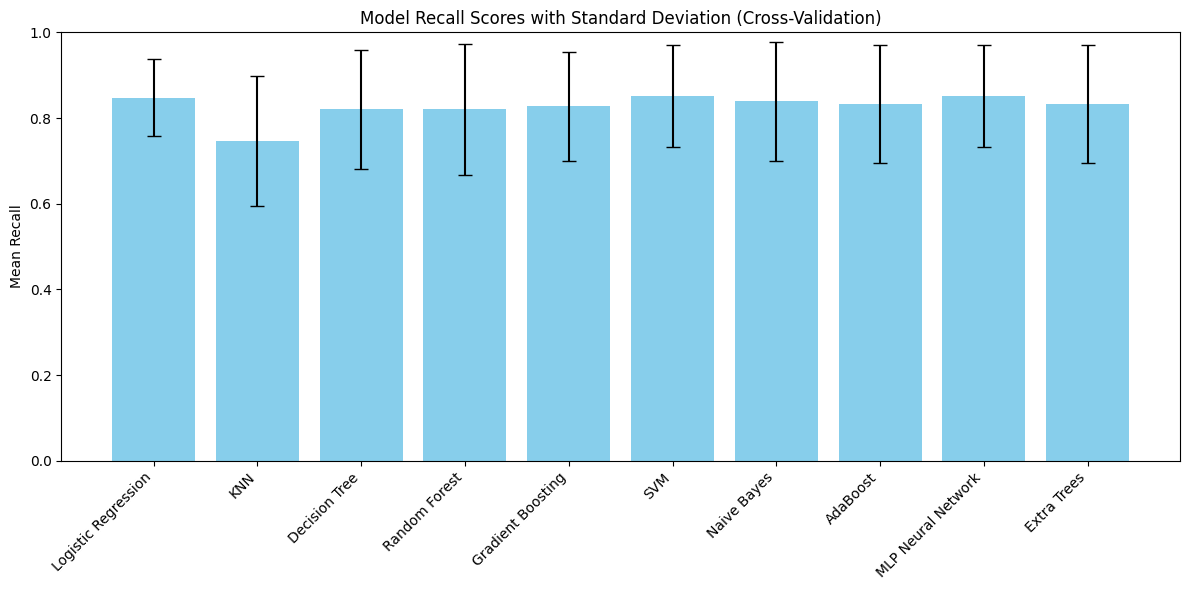

In [ ]:
# Model names
models = [
    "Logistic Regression", "KNN", "Decision Tree", "Random Forest", 
    "Gradient Boosting", "SVM", "Naive Bayes", "AdaBoost", 
    "MLP Neural Network", "Extra Trees"
]

# Mean recall scores
mean_recall = [
    0.8476, 0.7462, 0.8202, 0.8202, 0.8273, 0.8515, 0.8387, 0.8330, 0.8515, 0.8330
]

# Standard deviations
std_recall = [
    0.0896, 0.1522, 0.1385, 0.1527, 0.1273, 0.1201, 0.1390, 0.1374, 0.1201, 0.1374
]

# Plotting
plt.figure(figsize=(12,6))
plt.bar(models, mean_recall, yerr=std_recall, capsize=5, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Recall')
plt.title('Model Recall Scores with Standard Deviation (Cross-Validation)')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

#Ang bar chart ipinapakita kung gaano karaming positive cases ang nahuhuli (mean recall) ng bawat modelo, habang ang error bars ay sukat ng pagkakastable (standard deviation) sa k-fold CV. Pinakamataas at pinakakonsistent sina SVM at Logistic Regression (~0.85 recall, katamtamang SD); halos kasunod ang Gradient Boosting at iba pang tree ensembles (~0.82–0.83). Pinakamababa at pinakabarya-barya ang KNN (~0.75 recall, malaki ang SD). Ibig sabihin, kung recall ang prioridad, SVM o Logistic Regression ang pinakasulit, samantalang KNN ang pinakamahina sa setup na ito.

In [ ]:

# Models tuned
models = [
    "Logistic Regression", "KNN", "Decision Tree", "Random Forest", 
    "Gradient Boosting", "SVM", "Naive Bayes", "AdaBoost", 
    "MLP Neural Network", "Extra Trees"
]

# Best recall scores after tuning (Naive Bayes skipped tuning, use original score)
best_recall = [
    0.8533, 0.7667, 0.8487, 0.8376, 0.8273, 0.8771, 0.8387, 0.8828, 0.8828, 0.8515
]

# Plotting
plt.figure(figsize=(12,6))
bars = plt.bar(models, best_recall, color='lightgreen')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Best Recall Score')
plt.title('Best Recall Scores of Models After Hyperparameter Tuning')
plt.ylim(0.7, 1)

# Add score labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Sa tuned results, AdaBoost at MLP Neural Network ang pinakamataas ang recall (~0.883), sinundan ng SVM (~0.877). Kapantay halos sina Logistic Regression at Extra Trees (~0.85), habang pinakakulelat pa rin si KNN (~0.77). Ibig sabihin, kung recall ang sukatan, AdaBoost o MLP ang ipaprioritize.


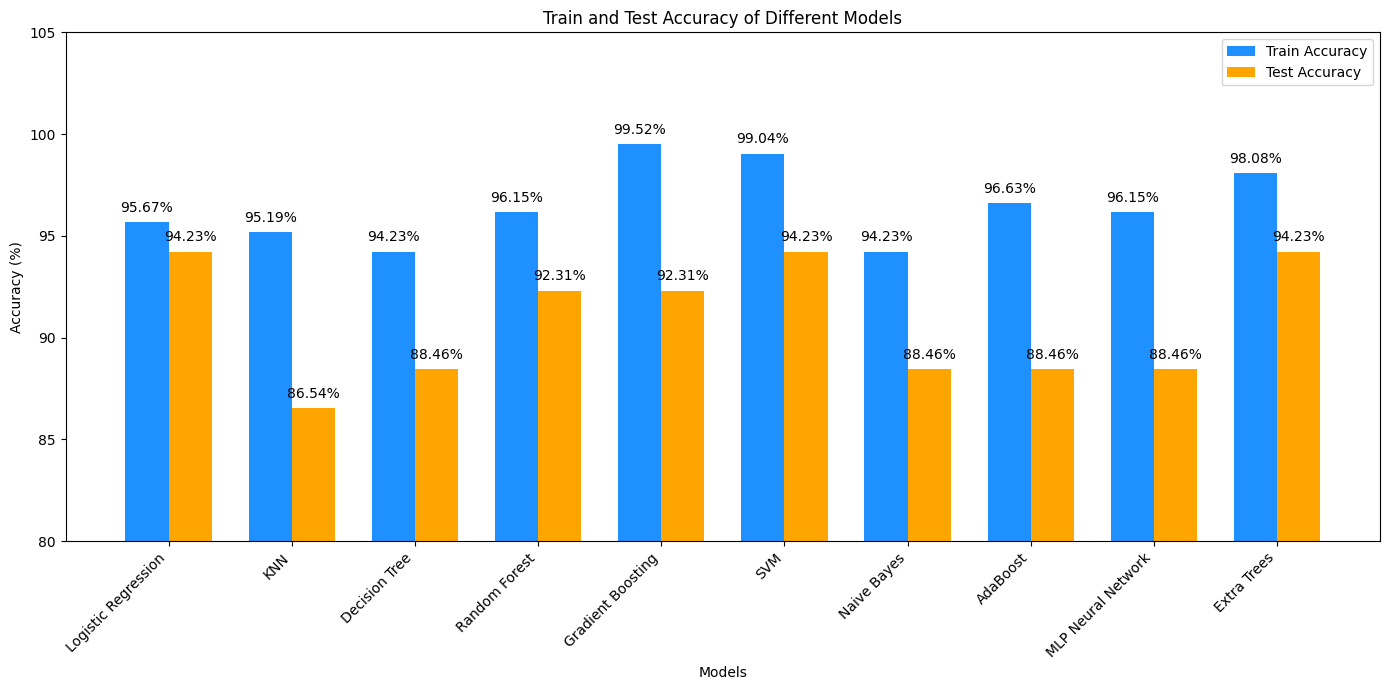

In [72]:

# Models
models = [
    "Logistic Regression", "KNN", "Decision Tree", "Random Forest",
    "Gradient Boosting", "SVM", "Naive Bayes", "AdaBoost",
    "MLP Neural Network", "Extra Trees"
]

# Train and Test Accuracy (in decimal form)
train_acc = [
    95.67, 95.19, 94.23, 96.15, 99.52, 99.04, 94.23, 96.63, 96.15, 98.08
]

test_acc = [
    94.23, 86.54, 88.46, 92.31, 92.31, 94.23, 88.46, 88.46, 88.46, 94.23
]

# Bar width and positions
bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(14,7))
plt.bar(index, train_acc, bar_width, label='Train Accuracy', color='dodgerblue')
plt.bar(index + bar_width, test_acc, bar_width, label='Test Accuracy', color='orange')

plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy of Different Models')
plt.xticks(index + bar_width / 2, models, rotation=45, ha='right')
plt.ylim(80, 105)
plt.legend()
plt.tight_layout()

# Add accuracy labels on top of bars
for i in range(len(models)):
    plt.text(i, train_acc[i] + 0.5, f"{train_acc[i]:.2f}%", ha='center', color='black')
    plt.text(i + bar_width, test_acc[i] + 0.5, f"{test_acc[i]:.2f}%", ha='center', color='black')

plt.show()

# Sa paghahambing ng accuracy, halos lahat ng modelo ay mataas ang training accuracy (≈94–100 %), ngunit bumababa ang test accuracy ng ilan—lalo na ang KNN (86.5 %) at tatlong “88 %” group (Decision Tree, Naive Bayes, AdaBoost, MLP). Pinaka-balanse ang Logistic Regression, SVM, at Extra Trees, na parehong ≈94 % sa train at test—hudyat ng mabuting generalization. Samantala, ang Gradient Boosting at Random Forest ay bahagyang mas mataas sa train kaysa test, ngunit nananatiling mahigit 92 % sa test, kaya maituturing ding maaasahan.